In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Very hacky, bad thing to do.
SRC_PATH = os.path.realpath('../src')
sys.path.append(SRC_PATH)

In [10]:
# Local imports.
from analysis import single_cycles
from defaults import PITCH_RATE, SAMPLE_RATE
from synthesis import EnvelopeMorpher, StimulusGenerator
from util import midi_to_hz, time_plot, stft_plot

In [4]:
# Synthesis parameters.
num_partials = 70
midi_pitch = 48
fm_depth = 0.1314
f0 = midi_to_hz(midi_pitch)

In [5]:
# Load env as linear amplitude. (CheapTrick calculates the power spectrum.)
env = single_cycles[0]['env']
env = np.sqrt(env)

In [6]:
# Modify the spectral envelopes.

morpher = EnvelopeMorpher(env)
morpher.shuffle_phase(num_shifts=5)

# Check that the shuffler is working.
print(env - morpher())

[[-5.52608617e-02 -5.78550286e-02  0.00000000e+00 ...  2.19933528e-05
   9.04079756e-05  7.25892754e-05]
 [-9.18521765e-02 -9.51580407e-02  0.00000000e+00 ... -4.66540141e-05
   5.06028890e-05  7.15422225e-06]
 [-1.27515805e-01 -1.31712128e-01  0.00000000e+00 ... -7.91525182e-05
  -1.02454900e-05 -4.46250148e-05]
 ...
 [-9.28414354e-02 -9.56106917e-02  0.00000000e+00 ...  7.62840412e-05
   1.54720768e-04  1.40396119e-04]
 [-9.73239595e-02 -1.01041120e-01  0.00000000e+00 ...  9.95198391e-05
   9.95770885e-05  1.34839050e-04]
 [-8.16368844e-02 -8.47694902e-02  0.00000000e+00 ...  2.11304326e-05
   7.38244433e-06  4.42977296e-05]]


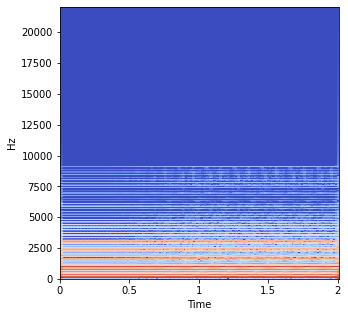

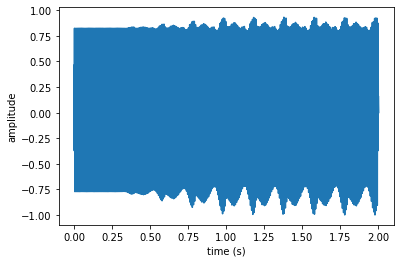

In [13]:
# Rock 'n' Roll.

generator = StimulusGenerator(sr=SAMPLE_RATE, pr=PITCH_RATE)

# FROZEN reconstruction condition.
x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=env,
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

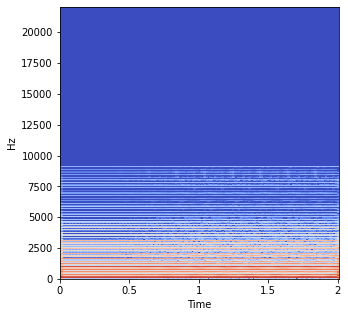

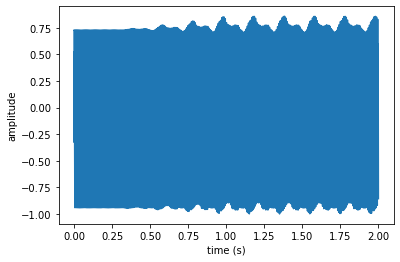

In [14]:
# Amplitude modulation phase-shuffled condition.

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=morpher(),
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

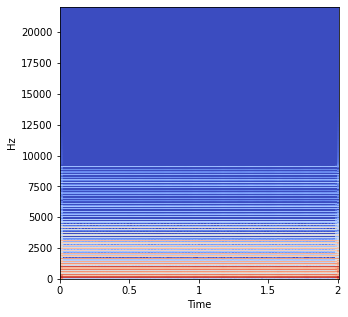

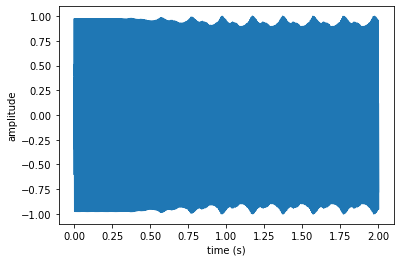

In [15]:
# PAM mode, pure amplitude modulation condition (a.k.a tremolo).

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=morpher(),
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
    synth_mode='PAM',
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))